In [1]:
import pipeline as pnl
import torch
from vol_calib import JointHestonLoss

In [2]:
spx = pnl.load_sp500()
spx.tail()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,returns
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,
Date,,,,,,
2002-04-11,1103.689941,1130.469971,1102.420044,1130.469971,1505600000,-0.023974
2002-04-12,1111.010010,1112.770020,1102.739990,1103.689941,1282100000,0.006610
2002-04-15,1102.550049,1114.859985,1099.410034,1111.010010,1120400000,-0.007644
2002-04-16,1128.369995,1129.400024,1102.550049,1102.550049,1341300000,0.023148
2002-04-17,1126.069946,1133.000000,1123.369995,1128.369995,1376900000,-0.002040


In [3]:
T = 252   # or whatever window length you want

x, S_tensor, S0 = pnl.prepare_return_window(spx, T=T)
S0

1126.0699462890625

In [4]:
opt_table = pnl.build_option_table()
opt_table.head(7)

,Strike,May2002,Jun2002
0,975,161.6,173.3
1,995,144.8,157.0
2,1025,120.1,133.1
3,1050,84.5,100.7
4,1075,64.3,82.5
5,1090,43.1,NaN
6,1100,35.6,65.5


In [5]:
opt_batch = pnl.build_option_batch(opt_table, S0, maturity_col="Jun2002")
opt_batch

OptionBatch(S=tensor([1126.0699]), K=tensor([[ 975.,  995., 1025., 1050., 1075., 1090., 1100., 1110., 1120., 1125.,
         1130., 1135., 1140., 1150., 1160., 1170., 1175., 1200., 1225., 1250.,
         1275.]]), tau=tensor([[0.1753, 0.1753, 0.1753, 0.1753, 0.1753, 0.1753, 0.1753, 0.1753, 0.1753,
         0.1753, 0.1753, 0.1753, 0.1753, 0.1753, 0.1753, 0.1753, 0.1753, 0.1753,
         0.1753, 0.1753, 0.1753]]), price=tensor([[173.3000, 157.0000, 133.1000, 100.7000,  82.5000,      nan,  65.5000,
              nan,  33.5000,  30.7000,      nan,  45.5000,  23.2000,  38.1000,
              nan,      nan,  27.7000,  19.6000,  13.2000,      nan,  13.2000]]), is_call=True)

In [6]:
latent = pnl.build_latent_model(T)
params = pnl.default_heston_params()
joint_model = JointHestonLoss(latent_model=latent, heston_params=params)
optimizer = pnl.build_optimizer(joint_model)

#### Run one epoch to test result

In [7]:
metrics = pnl.run_single_step(joint_model, optimizer, x, S_tensor, opt_batch)
metrics

{'loss': -409.5516357421875,
 'neg_loglik': -111810.25,
 'dyn_penalty': 8.49759453558363e-05,
 'opt_penalty': 2.634150981903076}

#### Full Training

In [8]:
history = pnl.train_epochs(joint_model, optimizer, x, S_tensor, opt_batch, epochs=300)

Epoch 0: loss=-415.01885986328125, dyn_penalty=7.281136640813202e-05, opt_penalty=2.6341488361358643
Epoch 20: loss=-688.2429809570312, dyn_penalty=5.076717570773326e-07, opt_penalty=2.634080410003662
Epoch 40: loss=-702.7692260742188, dyn_penalty=3.178420016070049e-08, opt_penalty=2.634080648422241
Epoch 60: loss=-703.080078125, dyn_penalty=5.242743128519578e-09, opt_penalty=2.634080648422241
Epoch 80: loss=-703.1474609375, dyn_penalty=4.479061566087239e-09, opt_penalty=2.634080648422241
Epoch 100: loss=-703.1487426757812, dyn_penalty=2.8547055830330237e-09, opt_penalty=2.634080648422241
Epoch 120: loss=-703.149169921875, dyn_penalty=1.7962141773963936e-09, opt_penalty=2.634080648422241
Epoch 140: loss=-703.1493530273438, dyn_penalty=1.656097592395156e-09, opt_penalty=2.634080648422241
Epoch 160: loss=-703.1492919921875, dyn_penalty=1.6441499273156523e-09, opt_penalty=2.634080648422241
Epoch 180: loss=-703.1493530273438, dyn_penalty=1.6366047406179973e-09, opt_penalty=2.63408064842224

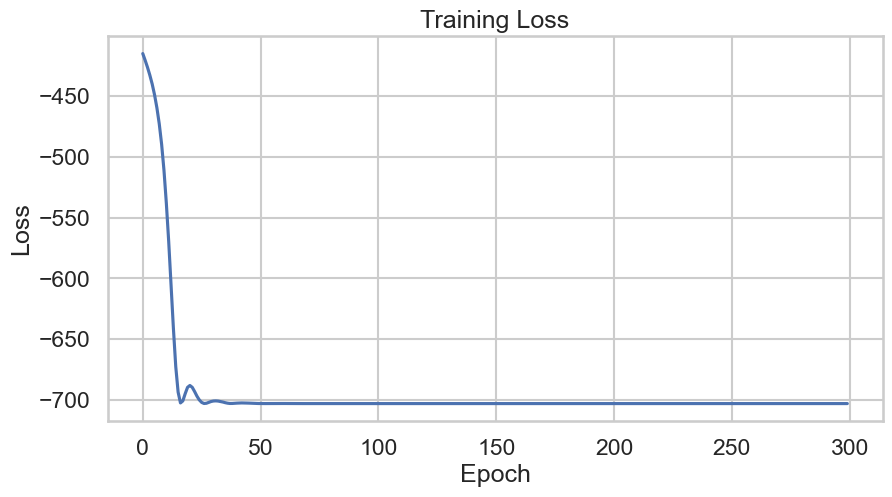

In [9]:
pnl.plot_loss(history)

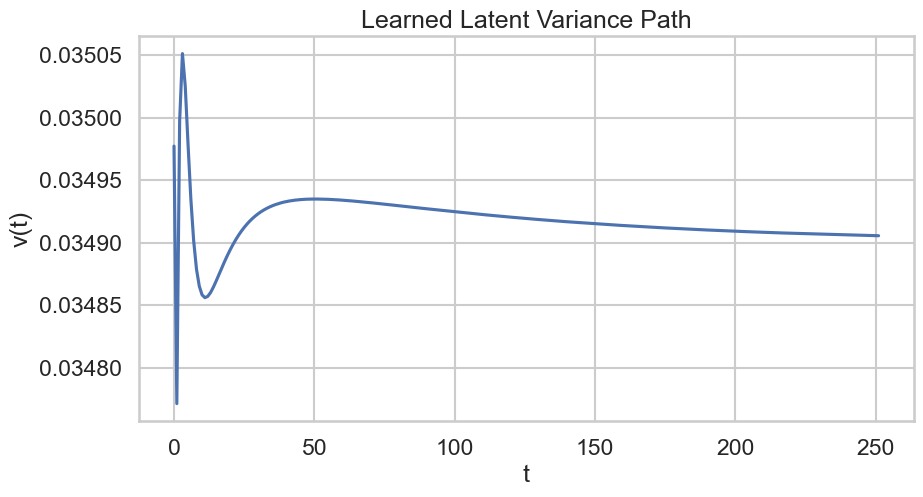

In [10]:
pnl.plot_variance_path(latent, x)

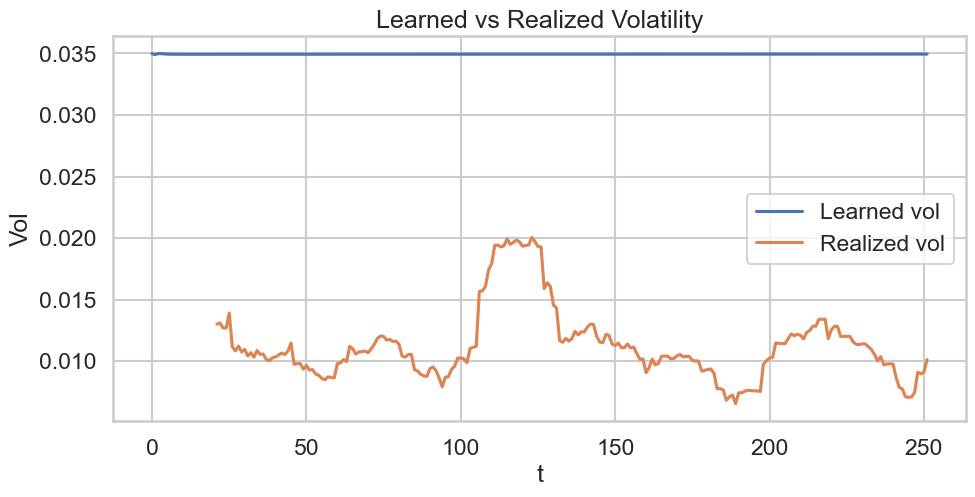

In [10]:
pnl.plot_realized_vs_learned(x, joint_model.latent_model, window=21)

/Users/yawasante/software/miniconda3/envs/light_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


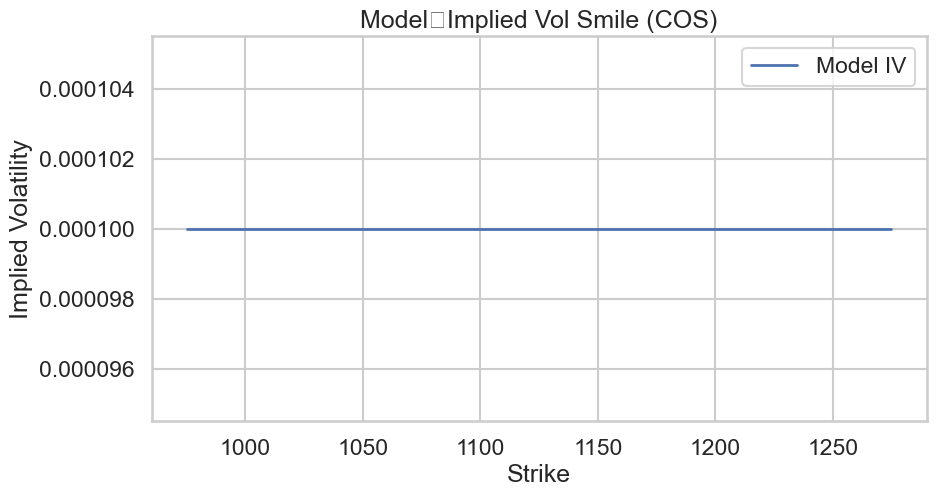

In [10]:
# Plot model-implied volatility smile using COS + BS inversion
pnl.plot_implied_vol_smile(
    joint_model=joint_model,
    opt_batch=opt_batch,
    r=0.019,
    q=0.012,
)

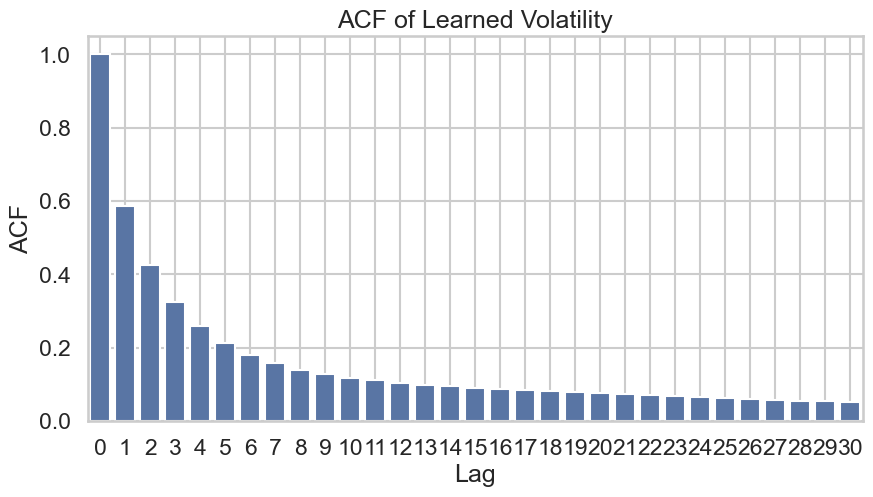

In [13]:
pnl.plot_vol_acf(joint_model.latent_model, x, lags=30)

In [14]:
# Save trained model to disk
pnl.save_model(joint_model, path="joint_heston_model.pt")

In [15]:
# Load your saved model for later downstream tasks or forecasting
restored_model = pnl.load_model(
    model_class=joint_model,   # same architecture instance
    path="joint_heston_model.pt"
)

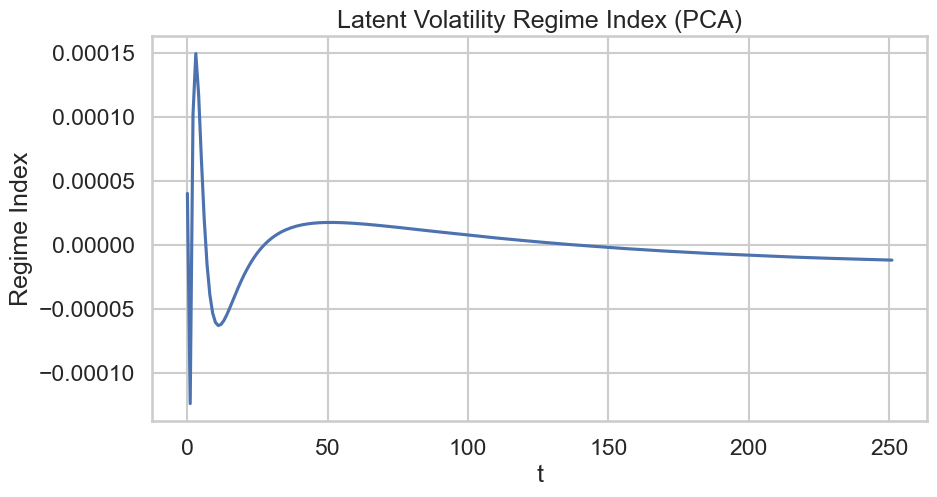

In [16]:
pnl.plot_vol_regime(restored_model.latent_model, x)

### View the Computational Graph of the Hybrid Model (Optional)

In [10]:
import cos_pricers
dt = 1.0/252.0

# Must NOT use run_single_step or example_training_step
out = joint_model(
    x=x,
    S=S_tensor,
    dt=dt,
    opt=opt_batch,
    r=0.019,
    q=0.012,
    cos_module=cos_pricers,   # whatever your cos module is named
)

loss_tensor = out["loss"]     # <--- REAL torch tensor (has grad_fn)
loss_tensor

tensor(-438.1623, grad_fn=<AddBackward0>)

In [ ]:
from torchviz import make_dot
dot = make_dot(loss_tensor, params=dict(joint_model.named_parameters()))
dot

In [ ]:
dot.render("joint_heston_graph", format="pdf")